In [1]:
import sys
sys.path.append('/eos/user/l/lkoller/SWAN_projects/data analysis 2024/Data loader')
sys.path.append('/eos/user/l/lkoller/SWAN_projects/data analysis 2024/commands')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from readTrc_4CH import Trc
from tqdm import tqdm
from cluster_finder import cfinder
from PIL import Image
from time import time
import scipy.signal as sci
pd.set_option("display.max_columns",150)

In [2]:
datafile = pd.read_csv('/eos/experiment/gbar/datasummary/datafile.txt', delimiter = '\t', low_memory = False)

In [8]:
dfl = datafile[datafile.FLAG == 'lpn'].reset_index(drop = True)
dfb = datafile[datafile.FLAG == 'pbar4'].reset_index(drop = True)

dfl = dfl[[True if str(val) != 'nan' else False for val in dfl.MCP6]]
dfb = dfb[[True if str(val) != 'nan' else False for val in dfb.MCP6]]

In [10]:
fll = [val for val in dfl.MCP6 if str(val) != 'nan']
fll = [val[:33]+'2022/'+val[33:] for val in fll]

flb = [val for val in dfb.MCP6 if str(val) != 'nan']
flb = [val[:33]+'2022/'+val[33:] for val in flb]

In [12]:
cl = pd.DataFrame(columns = ['filenumber','file','xpos','ypos','size','sum'])

for i in tqdm(range(len(fll))):
    temp_c = cfinder(fll[i], min_size = 3)
    temp_c.insert(0, 'file', [fll[i]]*len(temp_c))
    temp_c.insert(0, 'filenumber', [i]*len(temp_c))
    cl = pd.concat([cl, temp_c])
        
cb = pd.DataFrame(columns = ['filenumber','file','xpos','ypos','size','sum'])

for i in tqdm(range(len(flb))):
    temp_c = cfinder(flb[i], min_size = 3)
    temp_c.insert(0, 'file', [flb[i]]*len(temp_c))
    temp_c.insert(0, 'filenumber', [i]*len(temp_c))
    cb = pd.concat([cb, temp_c])

100%|██████████| 5263/5263 [10:51<00:00,  8.08it/s]


In [13]:
sizel = list(cl['size'])
suml = list(cl['sum'])

sizeb = list(cb['size'])
sumb = list(cb['sum'])

corr = len(dfl)/len(dfb)

In [14]:
bins = 260
ranges = np.linspace(min(suml+sumb), max(suml+sumb), bins+1)
histl = np.histogram(suml, bins = bins, range = (ranges[0], ranges[-1]))[0]
histb = np.histogram(sumb, bins = bins, range = (ranges[0], ranges[-1]))[0]
histb = np.array([val*corr for val in histb])
thresh = 76000
print('Number of events above', thresh, ' for mix:', len([1 for val in suml if val >= thresh]))
print('Number of events above', thresh, ' for bkg (with and without correction):', len([1 for val in sumb if val >= thresh]), ',', len([1 for val in sumb if val >= thresh])*corr)
print('Number of events in mix above', thresh, 'corrected for bkg (total and per spill):', len([1 for val in suml if val >= thresh]) - len([1 for val in sumb if val >= thresh])*corr, ',', (len([1 for val in suml if val >= thresh]) - len([1 for val in sumb if val >= thresh])*corr)/len(dfl))

Number of events above 76000  for mix: 6746
Number of events above 76000  for bkg (with and without correction): 14944 , 2211.927797833935
Number of events in mix above 76000 corrected for bkg (total and per spill): 4534.072202166065 , 5.820375099057849


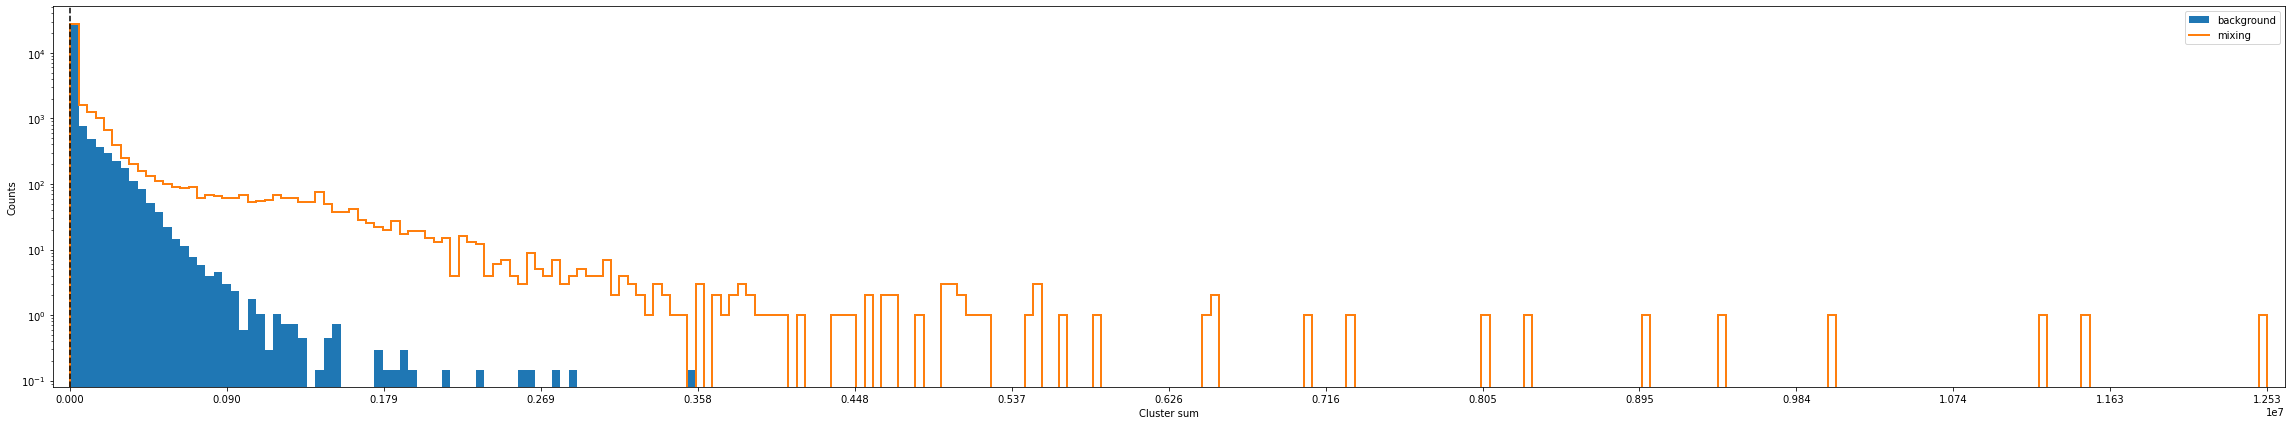

In [63]:
plt.figure(figsize = (40,7))
plt.xlabel('Cluster sum')
plt.ylabel('Counts')
plt.yscale('log')
plt.xlim(ranges[0]-100000, ranges[-1]+100000)
plt.xticks([round(val,4) for val in np.linspace(ranges[0],ranges[-1],15)])
plt.stairs(histb, ranges, fill = True, label = 'background')
plt.stairs(histl, ranges, fill = False, linewidth = 2, label = 'mixing')
#for i in ranges: plt.axvline(i, linestyle = '--', c = 'k', alpha = 0.2)
plt.axvline(thresh, c = 'k', linestyle = '--')
plt.legend(loc = 'best')

In [21]:
from PIL import Image

977.8697229261496 812.0802939876215 55.263142979509354


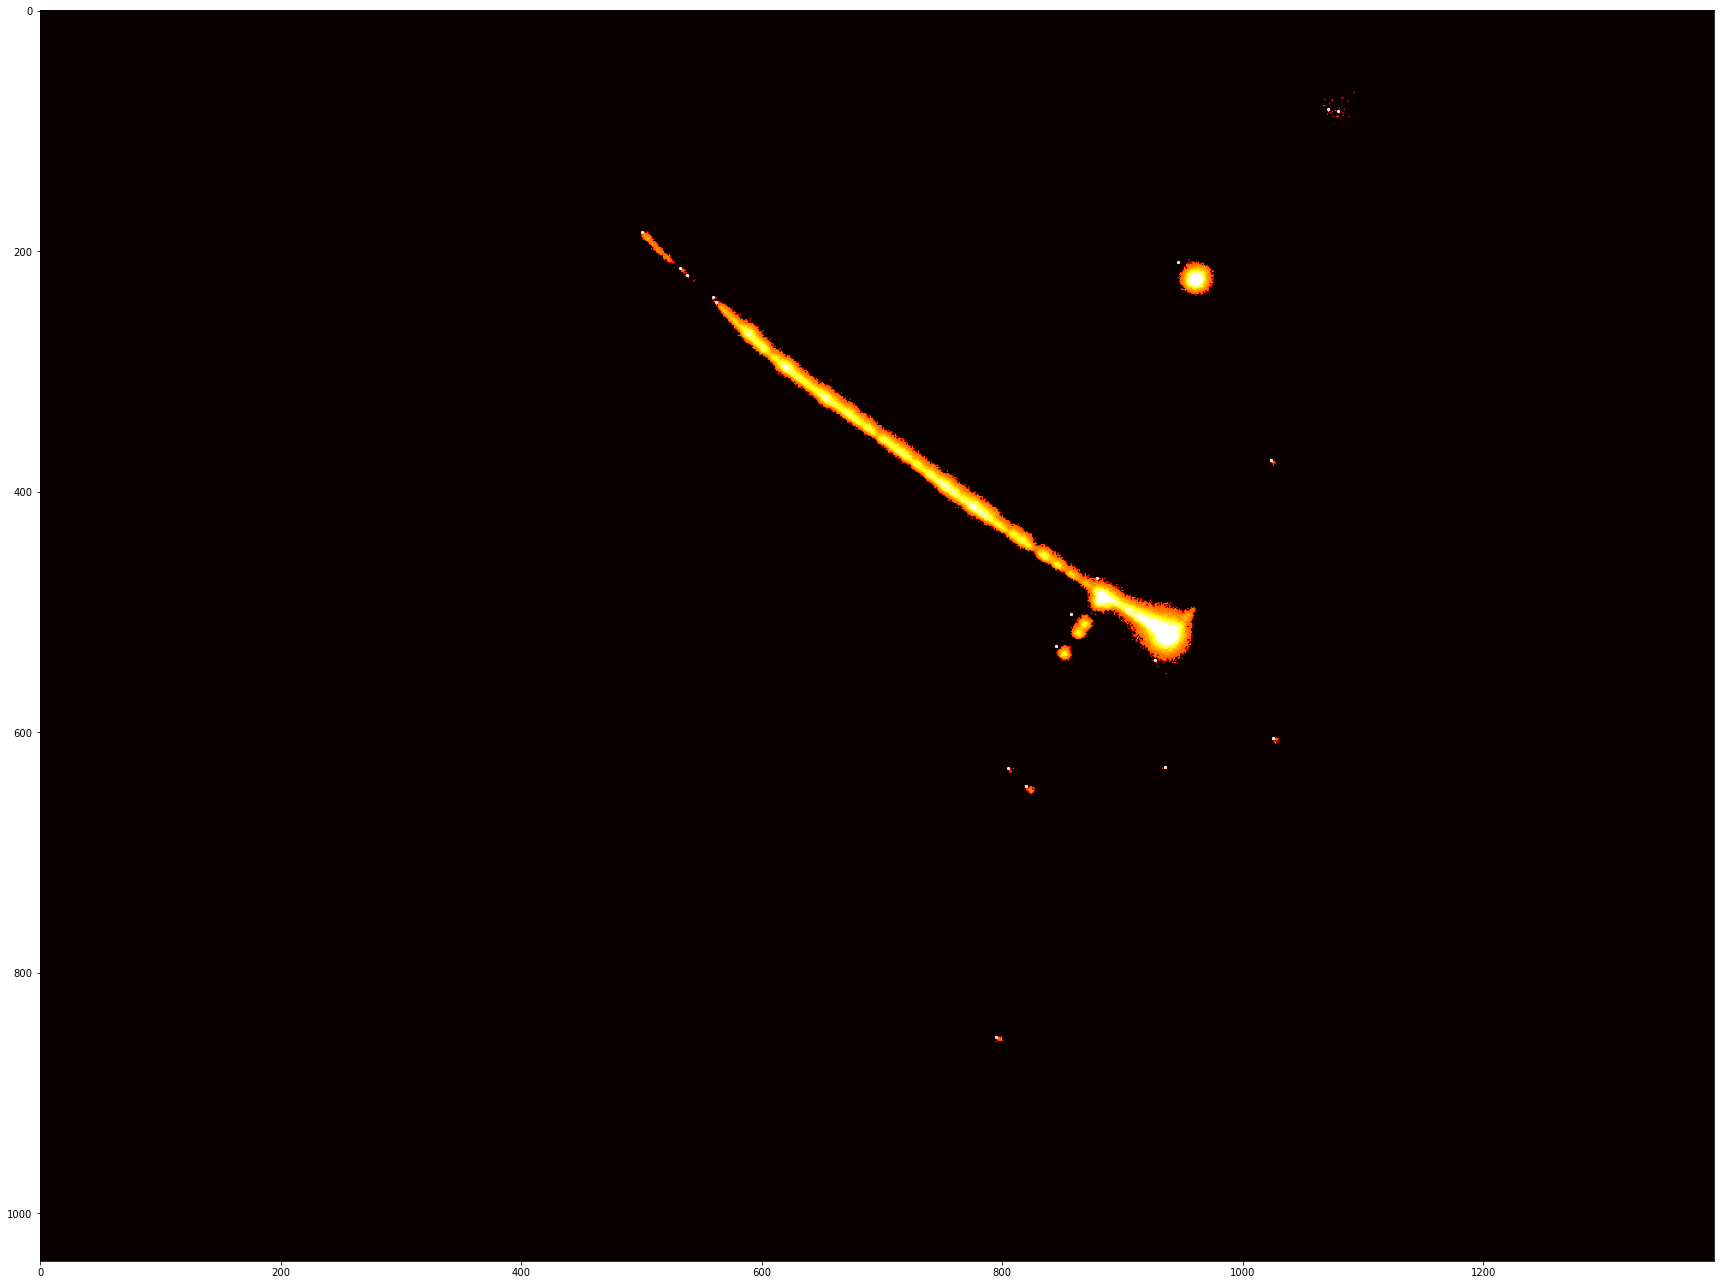

In [69]:
pos = 2000

file = '/eos/experiment/gbar/pgunpc/data/2022/22_10_20/PCO-SwY_exp_1_us_1666244164.977.tif'

curr_df = cfinder(file, min_size = 3)

fig = plt.figure(figsize = (30,30))
arr = np.array(Image.open(file))
thresh = np.average(arr) + 3*np.std(arr)
print(thresh, np.average(arr), np.std(arr))
arr[arr < thresh] = 0
arr[arr > 2000] = 2000
#arr = [[(val-thresh)/10+10 if val > 0 else val for val in bal] for bal in arr]
plt.imshow(arr, cmap = 'hot')
plt.scatter(curr_df.ypos, curr_df.xpos, s = 5, alpha = 0.9, c = 'white')

In [87]:
cll = pd.DataFrame(columns = ['filenumber','file','xpos','ypos','size','sum'])

for i in tqdm(range(len(fll))):
    temp_c = cfinder(fll[i], min_size = 3)
    if len([1 for val in temp_c['sum'] if val > 80000]) <= 1:
        temp_c.insert(0, 'file', [fll[i]]*len(temp_c))
        temp_c.insert(0, 'filenumber', [i]*len(temp_c))
        cll = pd.concat([cll, temp_c])

100%|██████████| 779/779 [00:35<00:00, 22.10it/s]


In [82]:
sizell = list(cll['size'])
sumll = list(cll['sum'])

sizeb = list(cb['size'])
sumb = list(cb['sum'])

corr = len(set(cll.filenumber))/len(dfb)

In [85]:
bins = 100
ranges = np.linspace(min(sumll+sumb), max(sumll+sumb), bins+1)
histll = np.histogram(sumll, bins = bins, range = (ranges[0], ranges[-1]))[0]
histb = np.histogram(sumb, bins = bins, range = (ranges[0], ranges[-1]))[0]
histb = np.array([val*corr for val in histb])
thresh = 76000
print('Number of events above', thresh, ' for mix:', len([1 for val in sumll if val >= thresh]))
print('Number of events above', thresh, ' for bkg (with and without correction):', len([1 for val in sumb if val >= thresh]), ',', len([1 for val in sumb if val >= thresh])*corr)
print('Number of events in mix above', thresh, 'corrected for bkg (total and per spill):', len([1 for val in sumll if val >= thresh]) - len([1 for val in sumb if val >= thresh])*corr, ',', (len([1 for val in sumll if val >= thresh]) - len([1 for val in sumb if val >= thresh])*corr)/len(set(cll.filenumber)))

Number of events above 76000  for mix: 53
Number of events above 76000  for bkg (with and without correction): 14944 , 161.84837545126354
Number of events in mix above 76000 corrected for bkg (total and per spill): -108.84837545126354 , -1.9096206219519918


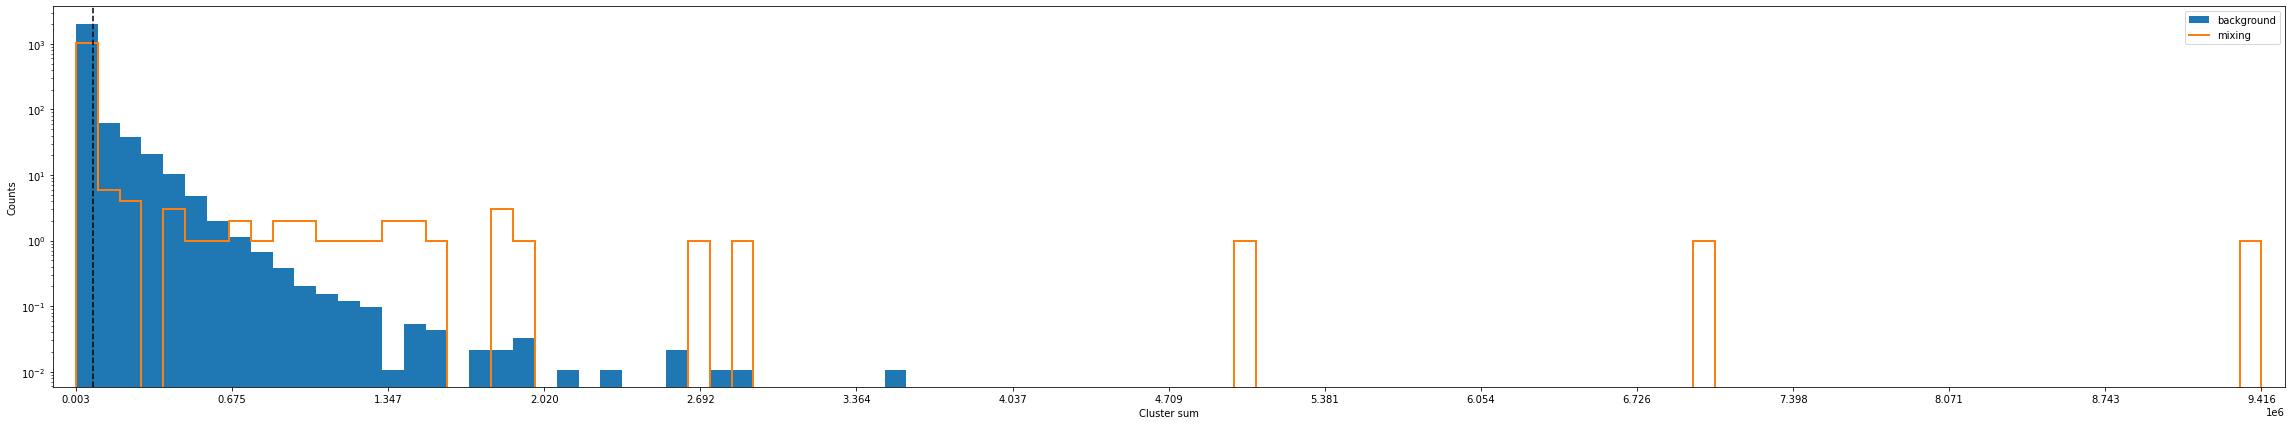

In [86]:
plt.figure(figsize = (40,7))
plt.xlabel('Cluster sum')
plt.ylabel('Counts')
plt.yscale('log')
plt.xlim(ranges[0]-100000, ranges[-1]+100000)
plt.xticks([round(val,4) for val in np.linspace(ranges[0],ranges[-1],15)])
plt.stairs(histb, ranges, fill = True, label = 'background')
plt.stairs(histll, ranges, fill = False, linewidth = 2, label = 'mixing')
#for i in ranges: plt.axvline(i, linestyle = '--', c = 'k', alpha = 0.2)
plt.axvline(thresh, c = 'k', linestyle = '--')
plt.legend(loc = 'best')